# Sentiment Classification (Binary) on Imdb Review Dataset


In [3]:
# Imports

import sys
import os
import re
import importlib
import numpy as np
from datetime import datetime
from bunch import Bunch
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from helpers.dataset import Dataset

glove_file = '/Users/gaurish/Drive/Workspace/Data/glove.6B/glove.6B.100d.txt'
data_root = '/Users/gaurish/Drive/Workspace/Data/aclImdb'
categories = ['neg', 'pos']

# Load dataset
ds = Dataset(num_classes=2)
print('[{}] Loading data ...'.format(datetime.now()))
ds.load_dataset_from_dir(os.path.join(data_root, 'train'), os.path.join(data_root, 'test'), categories)

print('[{}] Building vocab and loading glove embeddings ...'.format(datetime.now()))
ds.build_vocab()
ds.load_word_embeddings(glove_file)

print('[{}] Creating X, y sequences ...'.format(datetime.now()))
ds.compute_Xy()

print('[{}] Padding X, y sequences ...'.format(datetime.now()))
ds.pad_Xy(fixed_max_len=30)

[2019-12-24 18:08:54.019263] Loading data ...
[2019-12-24 18:09:31.605300] Building vocab and loading glove embeddings ...
[2019-12-24 18:09:37.332422] Creating X, y sequences ...
[2019-12-24 18:09:40.264171] Padding X, y sequences ...


In [6]:
def print_stats(ds):

    print('Number of Raw Training records: {} examples, {} labels '.format(
        len(ds.raw_train.data), len(ds.raw_train.target)))
    print('Number of Raw Test records: {} examples, {} labels '.format(
        len(ds.raw_test.data), len(ds.raw_test.target)))
    print('Target Names:', ds.raw_train.target_names)

    print('Label distribution in Training Set')
    print(np.asarray(np.unique(ds.raw_train.target, return_counts=True)).T)
    print('Label distribution in Test Set')
    print(np.asarray(np.unique(ds.raw_test.target, return_counts=True)).T)

    print('Vocab Size: ', len(ds.vocab))
    print('shape(word_embeddings): ', ds.word_embeddings.shape)
    print('Top 5 Words in word2index map', ['{}({})'.format(w, i) for w, i in ds.word2index.items() if i <= 5])

    print('shape(ds.X_train) = ', ds.X_train.shape, ' dtype(ds.X_train) = ', ds.X_train.dtype)
    print('shape(ds.y_train) = ', ds.y_train.shape, ' dtype(ds.y_train) = ', ds.y_train.dtype)
    print('shape(ds.X_test) = ', ds.X_test.shape, ' dtype(ds.X_test) = ', ds.X_test.dtype)
    print('shape(ds.y_test) = ', ds.y_test.shape, ' dtype(ds.y_test) = ', ds.y_test.dtype)

    print('Top 5 training examples:')
    for i in range(5):
        print('[#{}]\t {}'.format(i + 1, ds.y_train[i]))
        print('\t', ds.X_train[i][:10])
        print('\t', ' '.join(ds.raw_train.data[i].split()[:30]))
        
print_stats(ds)

Number of Raw Training records: 25000 examples, 25000 labels 
Number of Raw Test records: 25000 examples, 25000 labels 
Target Names: ['neg', 'pos']
Label distribution in Training Set
[[    0 12500]
 [    1 12500]]
Label distribution in Test Set
[[    0 12500]
 [    1 12500]]
Vocab Size:  53858
shape(word_embeddings):  (46197, 100)
Top 5 Words in word2index map ['$PAD$(0)', '$UNK$(1)', 'the(2)', 'of(3)', 'to(4)', 'and(5)']
shape(ds.X_train) =  (25000, 30)  dtype(ds.X_train) =  int64
shape(ds.y_train) =  (25000, 1)  dtype(ds.y_train) =  int64
shape(ds.X_test) =  (25000, 30)  dtype(ds.X_test) =  int64
shape(ds.y_test) =  (25000, 1)  dtype(ds.y_test) =  int64
Top 5 training examples:
[#1]	 [0]
	 [  30  926   11  155 1273 6414  295    6    2  306]
	 this movie is another christian propaganda film in the line of the omega code not that that is necessarily bad but for the fact that most propaganda films sacrifice sincerity
[#2]	 [1]
	 [    7   727    31 15582  6986  6432 33842     5    60   

In [7]:
maxN = min(10000, len(ds.X_train)) 
split = int(0.7 * maxN)

offset = 5000

X_train = ds.X_train[offset:offset+split]
y_train = ds.y_train[offset:offset+split]
X_train_seqlen = ds.X_train_seqlen[offset:offset+split]

X_val = ds.X_train[offset+split:offset+maxN]
y_val = ds.y_train[offset+split:offset+maxN]
X_val_seqlen = ds.X_train_seqlen[offset+split:offset+maxN]

word_embeddings = ds.word_embeddings

print('shape(X_train) = ', X_train.shape, ' dtype(X_train) = ', X_train.dtype)
print('shape(y_train) = ', y_train.shape, ' dtype(y_train) = ', y_train.dtype)
print('shape(X_val) = ', X_val.shape, ' dtype(X_val) = ', X_val.dtype)
print('shape(y_val) = ', y_val.shape, ' dtype(y_val) = ', y_val.dtype)
    
print('Label distribution in Training Set')
print(np.asarray(np.unique(y_train, return_counts=True)).T)
print('Label distribution in Validation Set')
print(np.asarray(np.unique(y_val, return_counts=True)).T)

shape(X_train) =  (7000, 30)  dtype(X_train) =  int64
shape(y_train) =  (7000, 1)  dtype(y_train) =  int64
shape(X_val) =  (3000, 30)  dtype(X_val) =  int64
shape(y_val) =  (3000, 1)  dtype(y_val) =  int64
Label distribution in Training Set
[[   0 3532]
 [   1 3468]]
Label distribution in Validation Set
[[   0 1483]
 [   1 1517]]


In [8]:
from helpers.utils import mini_batches
from helpers.evaluate import evaluate_model, predict_instance

class DeepModel:
    
    def __init__(self, model, lr):
        self.model = model
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_op = nn.BCELoss()  # binary cross entropy loss

        self.model.set_optimizer(self.optimizer)
        self.model.set_loss_op(self.loss_op)

        self.epoch_losses = []
        self.epoch_metrics = []
        self.train_losses = []
        self.val_losses = []
        

    def train(self, num_epochs, train_X, train_y, train_X_seqlen, val_X, val_y, val_X_seqlen, epoch_interval_for_lr = 3):
        for epoch in range(num_epochs):

            #X_train, y_train, X_train_seqlen = shuffle(X_train, y_train, X_train_seqlen, random_state=17)
            epoch_loss = self.model.run_epoch(train_X, train_y, train_X_seqlen)

            accuracy1, correct1, total1, loss1 = evaluate_model(self.model, train_X, train_y, train_X_seqlen, self.model.config.batch_size)
            accuracy2, correct2, total2, loss2 = evaluate_model(self.model, val_X, val_y, val_X_seqlen, self.model.config.batch_size)

            self.epoch_losses.append(epoch_loss)
            self.train_losses.append(loss1)
            self.val_losses.append(loss2)
            self.epoch_metrics.append('Training: {:.3f}% (={}/{}) L={:.5f}, Validation: {:.3f}% (={}/{}), L={:.5f}'.format(
                accuracy1, correct1, total1, loss1, accuracy2, correct2, total2, loss2))
            print('Epoch: {}/{}, Loss: {:.8f}, {}'.format(epoch+1, num_epochs, self.epoch_losses[-1], self.epoch_metrics[-1]))

            if (epoch + 1) % epoch_interval_for_lr == 0:
                # reduce learning rate
                for g in self.model.optimizer.param_groups:
                    g['lr'] = g['lr'] / 2                    
                print('Updated Learning Rate = ', set(g['lr'] for g in self.model.optimizer.param_groups))
   

    def plot_loss(self):
        
        plt.plot(self.train_losses)
        plt.plot(self.val_losses)
        plt.title(type(self.model).__name__)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'validation loss'], loc='upper right')
        plt.show()

        
    def evaluate(self, test_X, test_y, test_X_seqlen):
        accuracy, correct, total, loss = evaluate_model(self.model, test_X, test_y, test_X_seqlen, self.model.config.batch_size)
        metric = '{:.3f}% (={}/{}) L={:.5f}'.format(accuracy, correct, total, loss)
        print('Test Set Metric: ', metric)
        
        
    def predict(self, ds, input_texts = ['this is a good movie', 'this is worst movie i have seen']):
        for text in input_texts:
            lbl, score = predict_instance(self.model, ds, text)
            print('LABEL = {}, SCORE={:.4f}, INPUT = {}'.format(lbl, score, text))
        

# TextRNN

In [9]:
config = Bunch()
config.vocab_size, config.embed_size = word_embeddings.shape
config.output_size = 1
config.hidden_size = 50
config.num_lstm_layers = 2
config.isBidirectional = True
config.dropout_p = 0.5
config.batch_size = 64
config.lr = 0.001

from helpers.TextRNN import TextRNN

tm = TextRNN(config, torch.from_numpy(word_embeddings).type(torch.FloatTensor))
textRnn = DeepModel(tm, config.lr)

Epoch: 1/10, Loss: 0.68477466, Training: 61.529% (=4307/7000) L=0.65887, Validation: 60.567% (=1817/3000), L=0.66509
Epoch: 2/10, Loss: 0.63918760, Training: 67.743% (=4742/7000) L=0.59877, Validation: 66.100% (=1983/3000), L=0.61282
Epoch: 3/10, Loss: 0.59772391, Training: 69.886% (=4892/7000) L=0.56997, Validation: 67.967% (=2039/3000), L=0.59445
Updated Learning Rate =  {0.0005}
Epoch: 4/10, Loss: 0.57159571, Training: 71.457% (=5002/7000) L=0.55234, Validation: 68.833% (=2065/3000), L=0.58169
Epoch: 5/10, Loss: 0.55951178, Training: 71.900% (=5033/7000) L=0.54281, Validation: 68.467% (=2054/3000), L=0.57884
Epoch: 6/10, Loss: 0.54776781, Training: 73.300% (=5131/7000) L=0.52869, Validation: 68.833% (=2065/3000), L=0.57507
Updated Learning Rate =  {0.00025}
Epoch: 7/10, Loss: 0.53530881, Training: 72.900% (=5103/7000) L=0.52962, Validation: 69.700% (=2091/3000), L=0.58061
Epoch: 8/10, Loss: 0.52742489, Training: 73.286% (=5130/7000) L=0.52294, Validation: 69.533% (=2086/3000), L=0.5

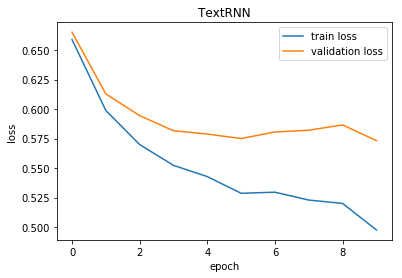

==== EVALUATION ===== 
Test Set Metric:  69.552% (=17388/25000) L=0.57113
==== PREDICT ===== 
LABEL = 1, SCORE=0.9564, INPUT = this is a good movie
LABEL = 0, SCORE=0.0669, INPUT = this is worst movie i have seen


In [10]:
textRnn.train(10, X_train, y_train, X_train_seqlen, X_val, y_val, X_val_seqlen)

textRnn.plot_loss()

print('==== EVALUATION ===== ')
textRnn.evaluate(ds.X_test, ds.y_test, ds.X_test_seqlen)

print('==== PREDICT ===== ')
textRnn.predict(ds)

# TextCNN

In [11]:
config = Bunch()
config.vocab_size, config.embed_size = word_embeddings.shape
config.output_size = 1
config.max_seq_len = 30
config.num_channels = 100
config.kernel_size = [3,4,5]
config.dropout_p = 0.5
config.batch_size = 64
config.lr = 0.001

from helpers.TextCNN import TextCNN

tm = TextCNN(config, torch.from_numpy(word_embeddings).type(torch.FloatTensor))

textCnn = DeepModel(tm, config.lr)

Epoch: 1/10, Loss: 0.67360445, Training: 64.957% (=4547/7000) L=0.61526, Validation: 61.400% (=1842/3000), L=0.64299
Epoch: 2/10, Loss: 0.59839306, Training: 71.486% (=5004/7000) L=0.55197, Validation: 66.467% (=1994/3000), L=0.60557
Epoch: 3/10, Loss: 0.54986495, Training: 76.943% (=5386/7000) L=0.49530, Validation: 69.067% (=2072/3000), L=0.58134
Updated Learning Rate =  {0.0005}
Epoch: 4/10, Loss: 0.50534542, Training: 80.614% (=5643/7000) L=0.45474, Validation: 70.033% (=2101/3000), L=0.56516
Epoch: 5/10, Loss: 0.47801284, Training: 83.543% (=5848/7000) L=0.42401, Validation: 70.200% (=2106/3000), L=0.56442
Epoch: 6/10, Loss: 0.44715470, Training: 85.543% (=5988/7000) L=0.39359, Validation: 69.967% (=2099/3000), L=0.56430
Updated Learning Rate =  {0.00025}
Epoch: 7/10, Loss: 0.41460866, Training: 84.986% (=5949/7000) L=0.38342, Validation: 70.000% (=2100/3000), L=0.57117
Epoch: 8/10, Loss: 0.39960243, Training: 86.471% (=6053/7000) L=0.36526, Validation: 70.400% (=2112/3000), L=0.5

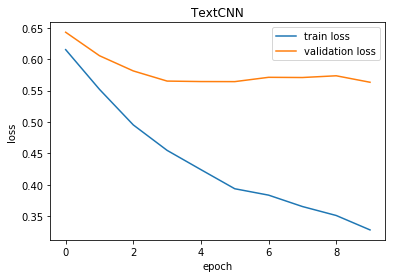

==== EVALUATION ===== 
Test Set Metric:  70.044% (=17511/25000) L=0.56514
==== PREDICT ===== 


RuntimeError: Given input size: (100x1x3). Calculated output size: (100x1x0). Output size is too small

In [12]:
textCnn.train(10, X_train, y_train, X_train_seqlen, X_val, y_val, X_val_seqlen)

textCnn.plot_loss()

print('==== EVALUATION ===== ')
textCnn.evaluate(ds.X_test, ds.y_test, ds.X_test_seqlen)

print('==== PREDICT ===== ')
textCnn.predict(ds)

# TextRCNN

In [31]:
config = Bunch()
config.vocab_size, config.embed_size = word_embeddings.shape
config.output_size = 1
config.hidden_size = 50
config.conv_feature_dim = 50
config.num_lstm_layers = 2
config.isBidirectional = True
config.dropout_p = 0.5
config.batch_size = 64
config.lr = 0.001

from helpers.TextRCNN import TextRCNN

tm = TextRCNN(config, torch.from_numpy(word_embeddings).type(torch.FloatTensor))

textRcnn = DeepModel(tm, config.lr)

Epoch: 1/10, Loss: 0.67463091, Training: 65.900% (=4613/7000) L=0.62137, Validation: 64.600% (=1938/3000), L=0.63001
Epoch: 2/10, Loss: 0.61074100, Training: 69.800% (=4886/7000) L=0.57217, Validation: 69.533% (=2086/3000), L=0.58496
Epoch: 3/10, Loss: 0.57755034, Training: 70.829% (=4958/7000) L=0.55040, Validation: 69.600% (=2088/3000), L=0.57638
Updated Learning Rate =  {0.0005}
Epoch: 4/10, Loss: 0.55207982, Training: 72.371% (=5066/7000) L=0.53029, Validation: 70.700% (=2121/3000), L=0.56458
Epoch: 5/10, Loss: 0.53921947, Training: 73.257% (=5128/7000) L=0.52129, Validation: 70.200% (=2106/3000), L=0.56644
Epoch: 6/10, Loss: 0.52912344, Training: 74.371% (=5206/7000) L=0.50649, Validation: 71.533% (=2146/3000), L=0.55912
Updated Learning Rate =  {0.00025}
Epoch: 7/10, Loss: 0.51993279, Training: 74.057% (=5184/7000) L=0.50950, Validation: 71.233% (=2137/3000), L=0.56261
Epoch: 8/10, Loss: 0.50757709, Training: 74.386% (=5207/7000) L=0.50830, Validation: 70.933% (=2128/3000), L=0.5

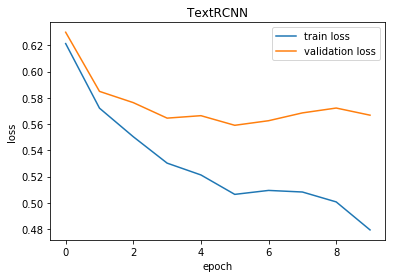

==== EVALUATION ===== 
Test Set Metric:  70.512% (=17628/25000) L=0.56393
==== PREDICT ===== 
LABEL = 1, SCORE=0.8877, INPUT = this is a good movie
LABEL = 0, SCORE=0.0204, INPUT = this is worst movie i have seen


In [32]:
textRcnn.train(10, X_train, y_train, X_train_seqlen, X_val, y_val, X_val_seqlen)

textRcnn.plot_loss()

print('==== EVALUATION ===== ')
textRcnn.evaluate(ds.X_test, ds.y_test, ds.X_test_seqlen)

print('==== PREDICT ===== ')
textRcnn.predict(ds)

# Play with Toy Data

In [16]:
## Understand Operations

word_emb = torch.tensor([
    [0,0,0,0,0],
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
    [6,6,6,6,6],
    [7,7,7,7,7],
    [8,8,8,8,8]]).type(torch.FloatTensor)

embeddings = nn.Embedding(num_embeddings=9, embedding_dim=5, padding_idx=0)   # V * d
embeddings.weight = nn.Parameter(word_emb, requires_grad=False)

lstm = nn.LSTM(input_size=5, hidden_size=7, num_layers=2, batch_first=True, bidirectional=True)

X = torch.tensor([[2,3,4],[6,7,0]]).type(torch.LongTensor)

print('X = ')
print(X)
eX = embeddings(X)
print('eX = ')
print(eX)
l_o, (h_n, c_n) = lstm(eX)
print('h_n = ')
print(h_n)
fi = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
print('fi = ')
print(fi)
fv = h_n.view(-1, h_n.size()[0] * h_n.size()[2])
print('fv = ')
print(fv)

X = 
tensor([[2, 3, 4],
        [6, 7, 0]])
eX = 
tensor([[[2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4.]],

        [[6., 6., 6., 6., 6.],
         [7., 7., 7., 7., 7.],
         [0., 0., 0., 0., 0.]]])
h_n = 
tensor([[[ 0.5482,  0.2351, -0.4200, -0.3394, -0.0956, -0.0134,  0.0895],
         [ 0.0891,  0.3210, -0.1345, -0.1041, -0.0707, -0.0436,  0.1138]],

        [[-0.0604, -0.3995,  0.6326,  0.2154,  0.0759,  0.0503,  0.4324],
         [-0.0050, -0.5505,  0.7971,  0.0950,  0.0368, -0.0156,  0.6376]],

        [[ 0.0334, -0.0287, -0.0240, -0.0541,  0.1743,  0.0037, -0.0273],
         [-0.0218, -0.0887,  0.0710, -0.0119,  0.1408,  0.0271, -0.0211]],

        [[-0.1519, -0.2877, -0.0317, -0.2194,  0.0748,  0.0074, -0.1565],
         [-0.1371, -0.2702, -0.0315, -0.2184,  0.1139,  0.0375, -0.1200]]],
       grad_fn=<StackBackward>)
fi = 
tensor([[ 0.5482,  0.2351, -0.4200, -0.3394, -0.0956, -0.0134,  0.0895, -0.0604,
         -0.3995,  0.6326,  0.2154

In [14]:
## Understand Operations

word_emb = torch.tensor([
    [0,0,0,0,0],
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
    [6,6,6,6,6],
    [7,7,7,7,7],
    [8,8,8,8,8]]).type(torch.FloatTensor)

embeddings = nn.Embedding(num_embeddings=9, embedding_dim=5, padding_idx=0)   # V * d
embeddings.weight = nn.Parameter(word_emb, requires_grad=False)

conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(2, 5))
pool1 = nn.MaxPool1d(7-2+1)


X = torch.tensor([[2,3,4,5,6,7,8],[8,7,6,5,4,3,2]]).type(torch.LongTensor)

print('X = ')
print(X)
eX = embeddings(X)
print('eX = ', eX.size())
print(eX)
eX = eX.unsqueeze(1)
print(eX.size())
c1 = conv1(eX).squeeze(3)
print('c1 = ', c1.size())
print(c1)
c1p = pool1(c1).squeeze(2)
print('c1p = ', c1p.size())
print(c1p)

X = 
tensor([[2, 3, 4, 5, 6, 7, 8],
        [8, 7, 6, 5, 4, 3, 2]])
eX =  torch.Size([2, 7, 5])
tensor([[[2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4.],
         [5., 5., 5., 5., 5.],
         [6., 6., 6., 6., 6.],
         [7., 7., 7., 7., 7.],
         [8., 8., 8., 8., 8.]],

        [[8., 8., 8., 8., 8.],
         [7., 7., 7., 7., 7.],
         [6., 6., 6., 6., 6.],
         [5., 5., 5., 5., 5.],
         [4., 4., 4., 4., 4.],
         [3., 3., 3., 3., 3.],
         [2., 2., 2., 2., 2.]]])
torch.Size([2, 1, 7, 5])
c1 =  torch.Size([2, 3, 6])
tensor([[[ 2.4183,  3.2166,  4.0149,  4.8132,  5.6116,  6.4099],
         [-1.5156, -2.1236, -2.7315, -3.3395, -3.9475, -4.5555],
         [-0.5851, -0.7366, -0.8881, -1.0396, -1.1911, -1.3426]],

        [[ 6.0257,  5.2274,  4.4290,  3.6307,  2.8324,  2.0341],
         [-4.5346, -3.9267, -3.3187, -2.7107, -2.1027, -1.4947],
         [-0.8594, -0.7079, -0.5564, -0.4049, -0.2534, -0.1019]]],
       grad_fn=<Squ

In [28]:
## Understand Operations
from torch.nn import functional as F

word_emb = torch.tensor([
    [0,0,0,0,0],
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
    [6,6,6,6,6],
    [7,7,7,7,7],
    [8,8,8,8,8]]).type(torch.FloatTensor)

embeddings = nn.Embedding(num_embeddings=9, embedding_dim=5, padding_idx=0)   # V * d
embeddings.weight = nn.Parameter(word_emb, requires_grad=False)

lstm = nn.LSTM(input_size=5, hidden_size=7, num_layers=4, batch_first=True, bidirectional=True)

X = torch.tensor([[2,3,4],[6,7,0]]).type(torch.LongTensor)

maxpool1 = nn.MaxPool1d(3)

print('X = ')
print(X)
eX = embeddings(X)
print('eX = ')
print(eX)
l_o, (h_n, c_n) = lstm(eX)
print('l_o = ')
print(l_o)
feature_map = torch.cat([l_o, eX], dim=2)
print('feature_map = ', feature_map.size())
print(feature_map)
conv_out = F.max_pool1d(feature_map.permute(0,2,1), feature_map.permute(0,2,1).shape[2]).squeeze(2)
print('conv_out = ', conv_out.size())
print(conv_out)

X = 
tensor([[2, 3, 4],
        [6, 7, 0]])
eX = 
tensor([[[2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4.]],

        [[6., 6., 6., 6., 6.],
         [7., 7., 7., 7., 7.],
         [0., 0., 0., 0., 0.]]])
l_o = 
tensor([[[-1.6737e-01,  2.8292e-02,  6.9431e-02, -2.8011e-02,  3.8141e-02,
          -3.4370e-02,  1.0937e-01, -2.7169e-02, -2.6018e-03, -1.3850e-01,
          -2.0993e-01, -7.8169e-02, -1.8952e-01, -1.0134e-01],
         [-2.5609e-01,  5.0148e-02,  1.0726e-01, -5.6000e-02,  5.5745e-02,
          -4.6080e-02,  1.3880e-01, -2.3304e-02, -1.4487e-02, -1.1174e-01,
          -2.0125e-01, -8.0383e-02, -1.6329e-01, -8.5320e-02],
         [-2.9957e-01,  6.5413e-02,  1.2522e-01, -8.3754e-02,  6.6857e-02,
          -4.5825e-02,  1.4098e-01, -1.7367e-02, -2.7340e-02, -6.9956e-02,
          -1.6518e-01, -6.3094e-02, -1.0805e-01, -5.9518e-02]],

        [[-1.6780e-01,  2.7649e-02,  6.8679e-02, -2.6114e-02,  3.7596e-02,
          -3.4416e-02,  1.0957e-01, -